https://daniel-saunders-phil.github.io/imagination_machine/posts/a-bayesian-decision-theory-workflow/

In [1]:
from functools import partial

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxtyping import Array, Float, UInt
from numpyro.handlers import condition, do, seed, trace
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

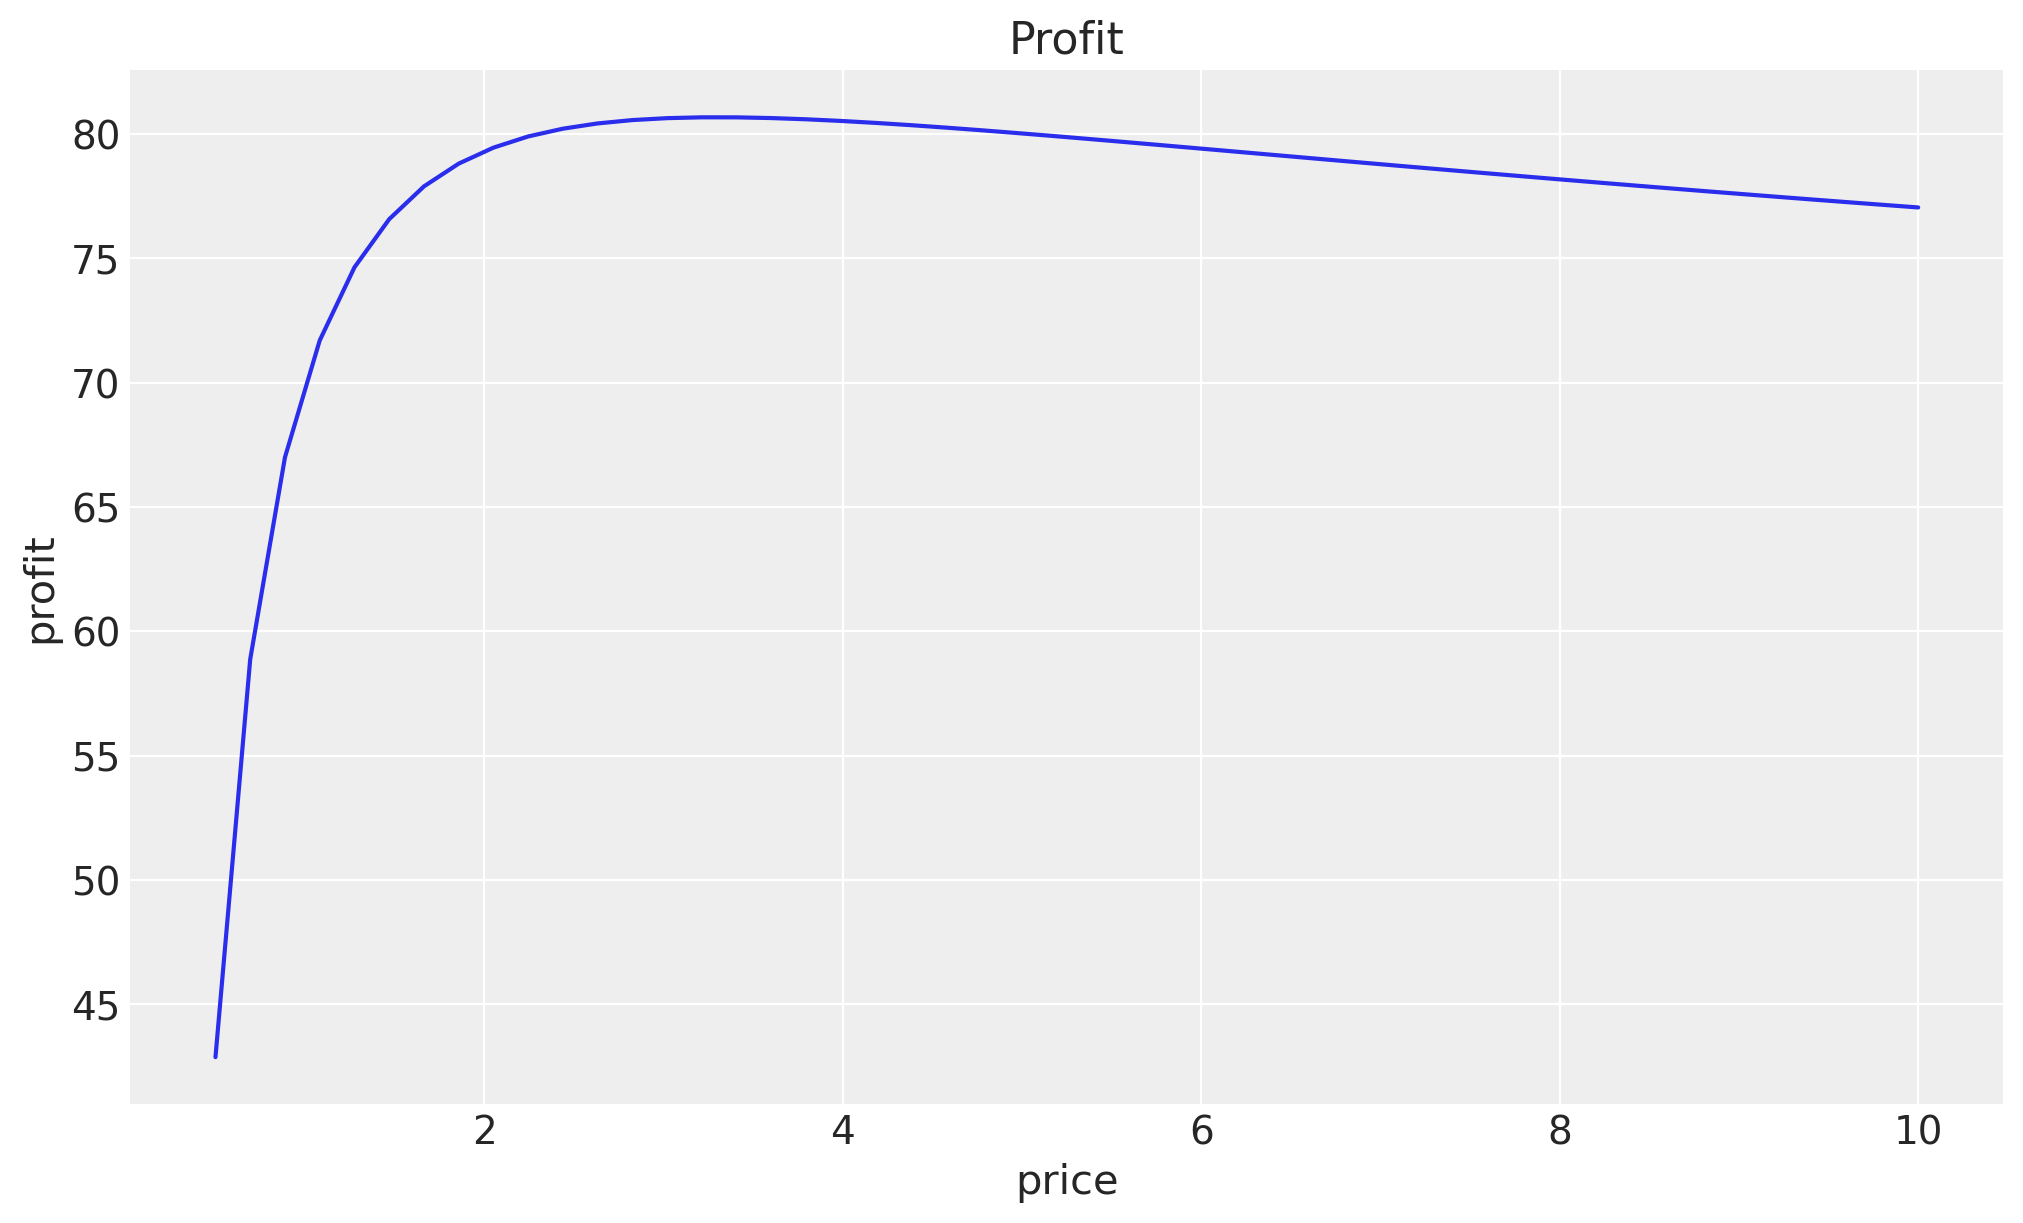

In [2]:
def unit_profit(price: Float[Array, " n"], c: float = 0.3) -> Float[Array, " n"]:
    return price - c


def profit(
    price: Float[Array, " n"], a: float, b: float, c: float = 0.3
) -> Float[Array, " n"]:
    return unit_profit(price, c) * a * price**b


price = jnp.linspace(start=0.5, stop=10, num=50)

a_true = 100.0
b_true = -1.1

fig, ax = plt.subplots()
ax.plot(price, profit(price, a=a_true, b=b_true, c=0.3))
ax.set(title="Profit", xlabel="price", ylabel="profit");

In [3]:
def model(price: Float[Array, " n"]) -> Float[Array, " n"]:
    mu_a = 100.0
    sigma_a = 40.0
    concentration_a = (sigma_a / mu_a) ** 2
    rate_a = mu_a / sigma_a**2

    a = numpyro.sample("a", dist.Gamma(concentration=concentration_a, rate=rate_a))

    b = numpyro.sample("b", dist.Normal(loc=0, scale=1))

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    mu = numpyro.deterministic("mu", a * price**b)

    numpyro.sample("sales", dist.Normal(loc=mu, scale=sigma))

    return mu

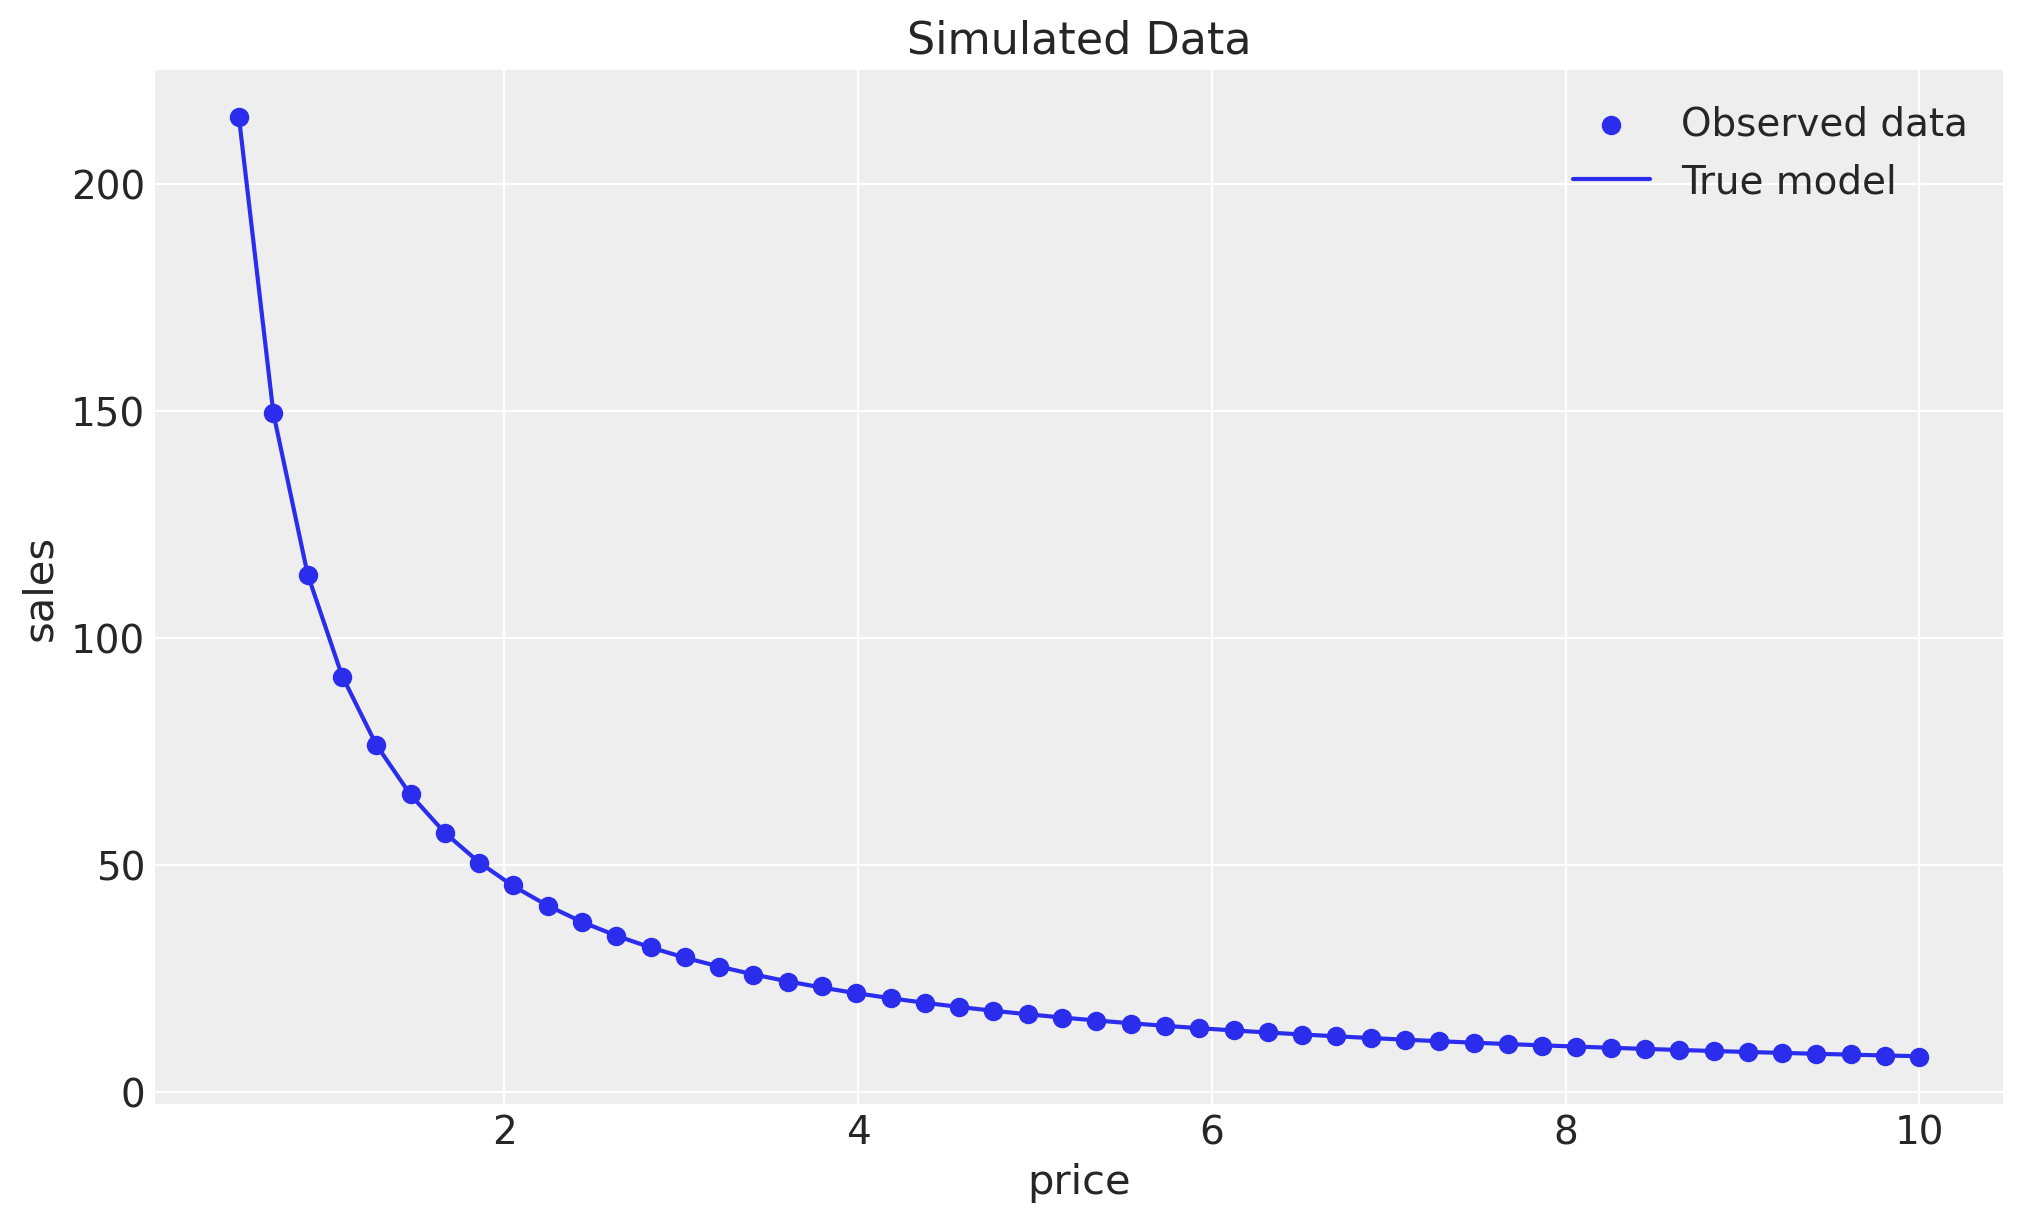

In [4]:
a_true = 100
b_true = -1.1

rng_key, rng_subkey = random.split(rng_key)

true_data = {"a": a_true, "b": b_true}

samples = trace(seed(do(model, true_data), rng_subkey)).get_trace(price)

sales_obs = samples["sales"]["value"]

fig, ax = plt.subplots()
ax.scatter(price, sales_obs, label="Observed data")
ax.plot(price, a_true * price**b_true, label="True model")
ax.legend()
ax.set(title="Simulated Data", xlabel="price", ylabel="sales");

In [5]:
conditioned_model = condition(model, {"sales": sales_obs})

nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_warmup=1_500, num_samples=1_000, num_chains=4)
mcmc.run(rng_key, price)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [6]:
idata = az.from_numpyro(
    mcmc,
    coords={"idx": range(len(price))},
    dims={"mu": ["idx"], "sales": ["idx"]},
)

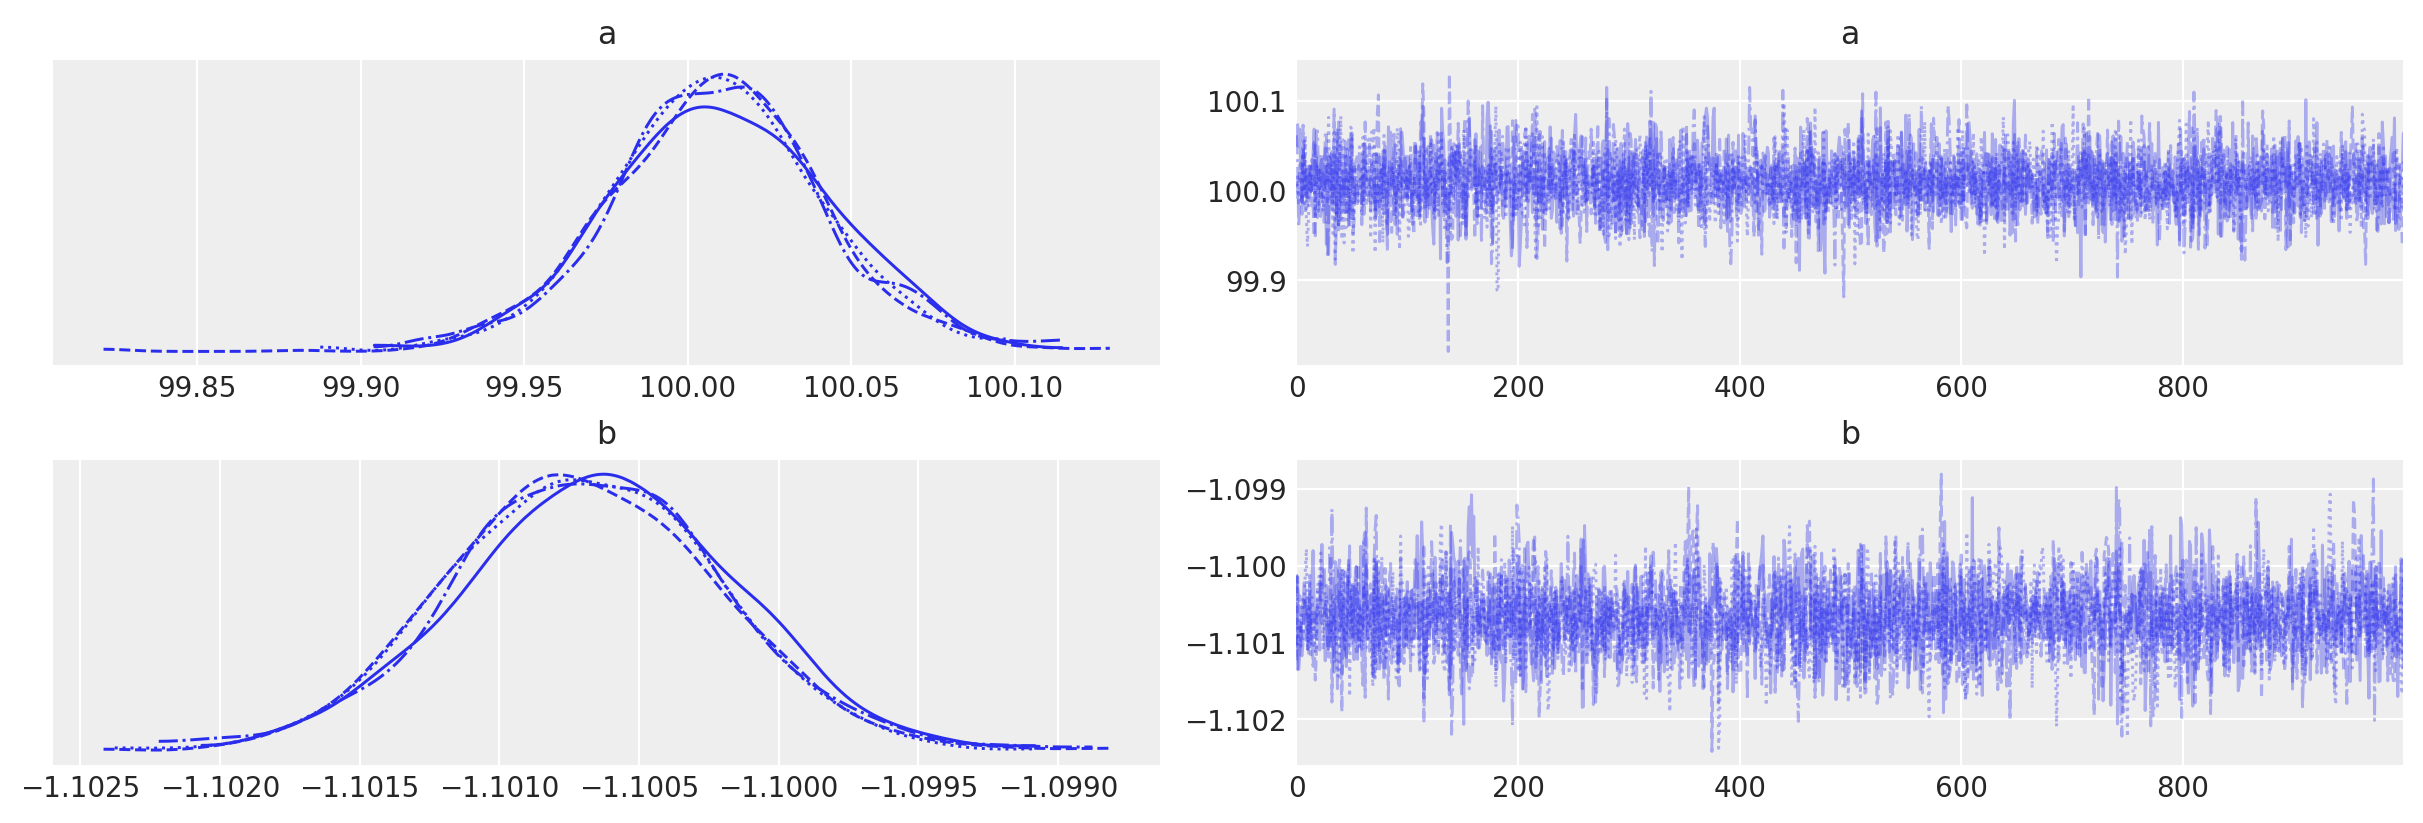

In [7]:
az.plot_trace(idata, var_names=["a", "b"]);

In [8]:
predictive = Predictive(model, mcmc.get_samples(), return_sites=["mu"])


def predictive_mean(
    rng_key: UInt[Array, "2"], price: Float[Array, " 1"]
) -> Float[Array, ""]:
    return jnp.mean(predictive(rng_key, price)["mu"])


rng_key, rng_subkey = random.split(rng_key)

predictive_mean_jit = jax.jit(partial(predictive_mean, rng_subkey))

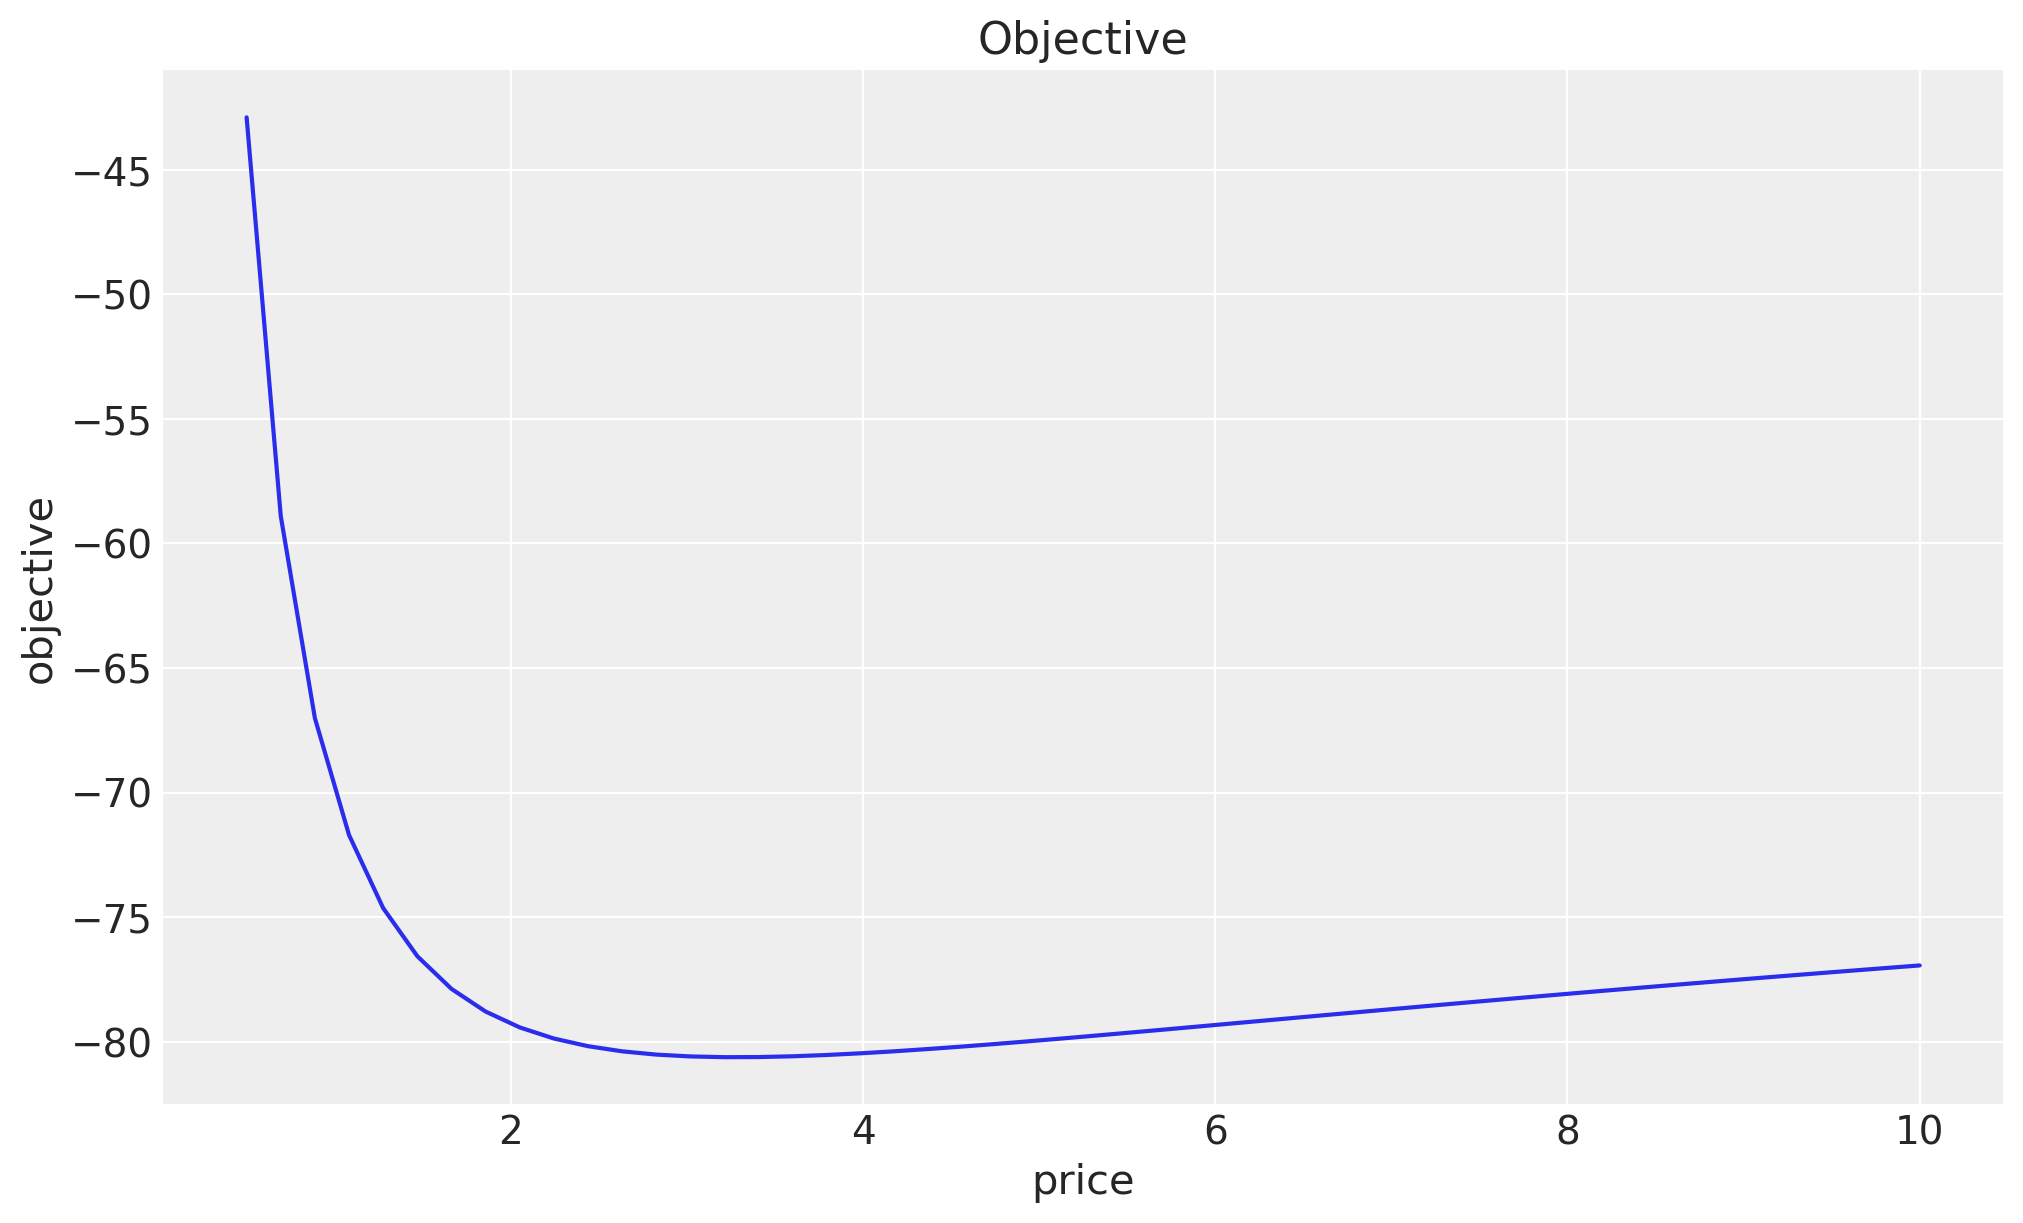

In [9]:
def objective(price: Float[Array, " 1"], c: float = 0.3) -> Float[Array, ""]:
    unit_profit = price - c
    mu = predictive_mean_jit(price)
    return (-1 * unit_profit * mu).reshape(())


fig, ax = plt.subplots()
ax.plot(price, jax.vmap(objective)(price.reshape(-1, 1)))
ax.set(title="Objective", xlabel="price", ylabel="objective");

In [10]:
result = jax.scipy.optimize.minimize(objective, x0=jnp.array([1.0]), method="BFGS")

result.x

Array([3.2797701], dtype=float32)

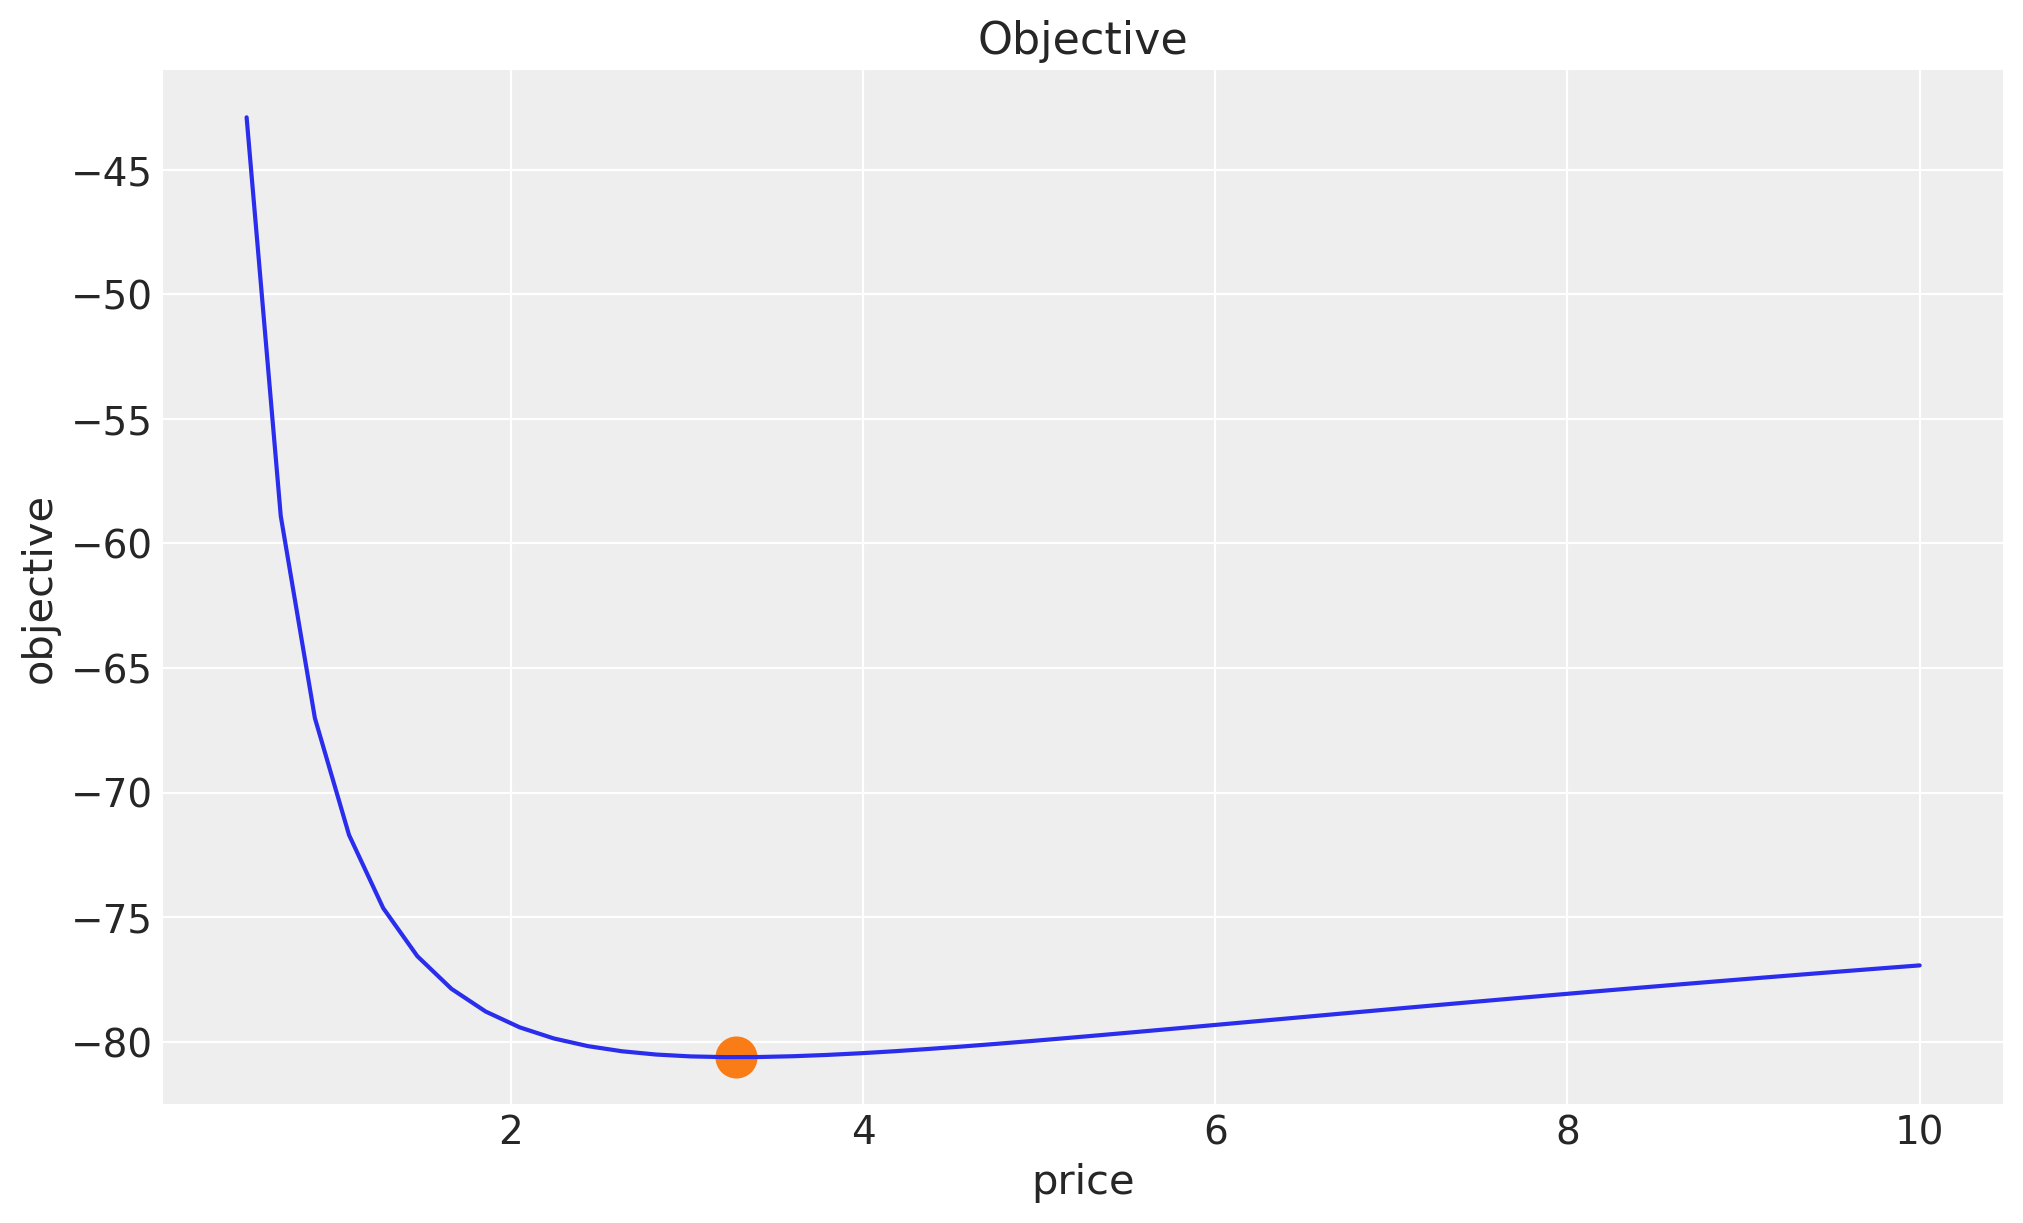

In [11]:
fig, ax = plt.subplots()
ax.plot(price, jax.vmap(objective)(price.reshape(-1, 1)))
ax.scatter(result.x, objective(result.x), color="C1", s=200)
ax.set(title="Objective", xlabel="price", ylabel="objective");